## Bayesian Classification (Fisher's) Linear Discriminant Analysis (LDA)

Importing necessary libraries and reading training data:

In [1]:
import numpy as np
import view.visualize as v
import utils.utils as utils

path_data="data/part2/ldaData.txt"

data=utils.read_data_from_txt(path_data,dim=(-1,2))

Defnining 2-dimensional data of the 3 different classes:

In [2]:
# specify the sample size of each class
c1_len=50
c2_len=43
c3_len=44

# data is divided into 3 classes
c1=data[:c1_len]
c2=data[c1_len:c1_len+c2_len]
c3=data[c1_len+c2_len:]

Defining labels:

In [3]:
# create label vector with classes 0, 1 and 2
y_true=np.hstack([np.zeros([c1_len]), 1 * np.ones([c2_len]), 2 * np.ones([c3_len])]).ravel()


Computing the mean of a given matrix across the 0-axis:

In [4]:
def compute_mean_vec(data):
    '''
    compute mean for each feature of the data for a class

    :param data:
    :return:
    '''
    return np.mean(data,axis=0)

Computing $S_b$

In [7]:
def compute_Sb_between_class_cov(data,**args):
    '''
    Computing the within class scatter matrix

    :param data: original data
    :param args: data of each class
    :return:
    '''
    m=compute_mean_vec(data)
    Sb = np.array(list(map(lambda c: len(c) * np.outer((compute_mean_vec(c) - m),
                                                  (compute_mean_vec(c) - m)),
                        args.values())))
    Sb=np.sum(Sb,axis=0)

    return Sb

# compute between class matrix
Sb=compute_Sb_between_class_cov(data=data,c1=c1,c2=c2,c3=c3)



Computing $S_w$

In [8]:
def compute_Sw_between_class_cov(**args):
    '''
    Computing the between class scatter matrix

    :param args: data of each class
    :return:
    '''
    Sw=np.array(list(map(lambda c: np.sum([np.outer((x - compute_mean_vec(c)),
                    (x - compute_mean_vec(c))) for x in c], axis=0),args.values())))

    Sw=np.sum(Sw,axis=0)

    return Sw

# compute within class matrix
Sw=compute_Sw_between_class_cov(c1=c1,c2=c2,c3=c3)

Computing Eigenvectors:

In [9]:
# compute all Eigenvectors of (Sw^-1 * Sb)
_,eigenvecs=np.linalg.eig(np.linalg.inv(Sw).dot(Sb))


Stacking all Eigenvectors to build matrix W:

In [10]:
# build matrix W consisting of each Eigenvector row wise
W = np.stack([eigenvecs[0],eigenvecs[1]],axis=0)


Compute projected data:

In [11]:
# compute the projected data by multiplying original 2-dim data with computed matrix W
data_lda = data.dot(W)


Compute bayesian posterior:

In [12]:
# compute bayesian posterior p(c|x)=p(c)p(x|c) for each class c using projected data and stack them together R^(N,dim)
probs=np.stack([len(data_lda[:c1_len]) / len(data_lda) * utils.gaussian_density_optim(data_lda, mu=np.mean(data_lda[:c1_len], axis=0), sigma=np.cov(data_lda[:c1_len], rowvar=False)),
                len(data_lda[c1_len:c1_len + c2_len]) / len(data_lda) * utils.gaussian_density_optim(data_lda, mu=np.mean(data_lda[c1_len:c1_len + c2_len], axis=0), sigma=np.cov(data_lda[c1_len:c1_len + c2_len], rowvar=False)),
                len(data_lda[c1_len + c2_len:]) / len(data_lda) * utils.gaussian_density_optim(data_lda, mu=np.mean(data_lda[c1_len + c2_len:], axis=0), sigma=np.cov(data_lda[c1_len + c2_len:], rowvar=False))], axis=1)


Computing predictions:

In [13]:
# predict the class for each sample by applying argmax
y_pred=np.argmax(probs,axis=1)

print("Accuracy:",np.sum(y_true==y_pred)/len(y_pred))
print("True predictions:",np.sum(y_true==y_pred), " out of ", len(y_true)," samples.")
print("Missclasified samples:",len(y_true)-np.sum(y_true==y_pred), " out of ", len(y_true)," samples.")


Accuracy: 0.8394160583941606
True predictions: 115  out of  137  samples.
Missclasified samples: 22  out of  137  samples.


Plotting the LDA classification results:

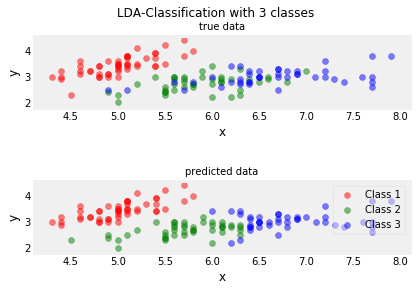

In [18]:
def plot_lda_classification(data,y_true,y_pred):
    import matplotlib.pyplot as plt

    fig, ax=plt.subplots(nrows=2,ncols=1)
    plt.subplots_adjust(hspace=1.0)

    label_dict = {0: 'Class 1', 1: 'Class 2', 2: 'Class 3'}
    colors=["red","green","blue","yellow","black","gray"]
    labels=["true data","predicted data"]

    # plot 2 subplots with true labels and predictions
    for i,(y,title) in enumerate(zip([y_true,y_pred],labels)):
        for label,color in zip(range(0,3),colors):
            ax[i].scatter(x=data[:, 0].real[y == label],
                        y=data[:, 1].real[y == label],
                        color=color,
                        alpha=0.5,
                        label=label_dict[label]
                        )
            # hide grid lines
            ax[i].grid(b=False)
            ax[i].set_title(title, fontsize="medium")
            ax[i].set_xlabel("x")
            ax[i].set_ylabel("y")



    leg = plt.legend(loc='best', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    fig.suptitle('LDA-Classification with 3 classes')

    plt.show()

# plot
plot_lda_classification(data=data, y_true=y_true, y_pred=y_pred)